# **Number classification algorithm**

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string

import tensorflow as tf
# Importing the required Keras modules containing model and layers
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras import backend as k
import h5py
from keras.models import model_from_json



Using TensorFlow backend.


# Generate datasets

In [2]:
def transform_dataset(dataset):
    labels = []
    letters = []
    for row in dataset:
        labels.append(row[-1])
        letters.append(np.array(row[:-1]).reshape(28,28))
           
    return np.asarray(letters), np.array(labels)      

In [3]:
%%time 

print("Creating train dataset...")
train_array = np.load('./train.npy')
x_train, y_train = transform_dataset(train_array)
print ("\nFinished creating train dataset\n")

Creating train dataset...

Finished creating train dataset

CPU times: user 892 ms, sys: 1.73 s, total: 2.62 s
Wall time: 9.28 s


In [4]:
%%time 

print("Creating testing dataset")
test_array = np.load('./test.npy')
x_test, y_test = transform_dataset(test_array)
print ("\nFinished creating test dataset\n")

Creating testing dataset

Finished creating test dataset

CPU times: user 113 ms, sys: 37.1 ms, total: 150 ms
Wall time: 150 ms


In [5]:
%%time 

    
print("Creating validation dataset...")
validation_array = np.load('./validation.npy')
x_validation, y_validation = transform_dataset(validation_array)
print ("\nFinished creating validation dataset\n")

Creating validation dataset...

Finished creating validation dataset

CPU times: user 82.5 ms, sys: 14.4 ms, total: 97 ms
Wall time: 99.4 ms


In [6]:
def changeLabbel(labbel):
    return (list(string.ascii_uppercase))[labbel - 1]

# CNN test

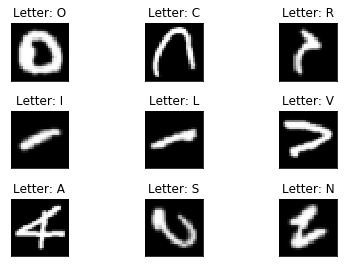

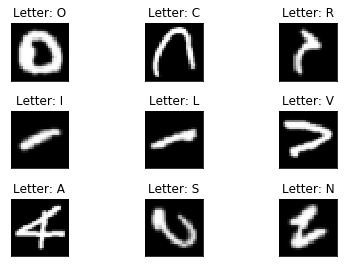

In [7]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_test[i], cmap='gray', interpolation='none')
    plt.title("Letter: {}".format(changeLabbel(y_test[i])))
    plt.xticks([])
    plt.yticks([])
fig

In [8]:
print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(120000, 28, 28)
(15375, 28, 28)
(5125, 28, 28)


In [9]:
# input image dimensions
img_rows, img_cols = 28, 28

#reshaping
#this assumes our data format
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).
if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
#more reshaping
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('X_train shape:', x_train.shape) #X_train shape: (60000, 28, 28, 1)
print('X_test shape:', x_test.shape) #X_train shape: (60000, 28, 28, 1)

('X_train shape:', (120000, 28, 28, 1))
('X_test shape:', (15375, 28, 28, 1))


In [10]:
#set number of categories
num_category = 27
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_category)
y_test = keras.utils.to_categorical(y_test, num_category)

In [11]:
##model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(num_category, activation='softmax'))

In [12]:
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [19]:
batch_size = 128
num_epoch = 3
#steps_epoch = 100
#steps_validation = 3

#data = steps * batch_size (numero de data q pego a cada epoca - total do treino)

#model training
model_log = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
 #         steps_per_epoch = steps_epoch, 
          verbose=1,
 #         validation_steps = steps_validation,
          validation_data=(x_test, y_test))

Train on 120000 samples, validate on 15375 samples
Epoch 1/3
120000/120000 [==============================] - 241s 2ms/step - loss: 0.6387 - accuracy: 0.8033 - val_loss: 0.2998 - val_accuracy: 0.9063
Epoch 2/3
120000/120000 [==============================] - 268s 2ms/step - loss: 0.4092 - accuracy: 0.8717 - val_loss: 0.2566 - val_accuracy: 0.9198
Epoch 3/3
120000/120000 [==============================] - 266s 2ms/step - loss: 0.3482 - accuracy: 0.8897 - val_loss: 0.2333 - val_accuracy: 0.9257


In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]) #Test loss: 0.0296396646054
print('Test accuracy:', score[1]) #Test accuracy: 0.9904

('Test loss:', 0.23329363170096545)
('Test accuracy:', 0.9256585240364075)


KeyError: 'acc'

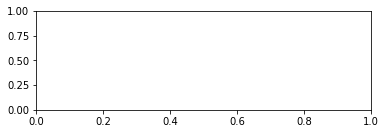

In [22]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

In [ ]:
#Save the model
# serialize model to JSON
model_digit_json = model.to_json()
with open("model_digit.json", "w") as json_file:
    json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights("model_digit.h5")
print("Saved model to disk")

# Use CNN created

In [23]:
# load json and create model
json_file = open('model_digit.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_digit.h5")
print("Loaded model from disk")
 

Loaded model from disk


In [26]:

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

15375/15375 [==============================] - 7s 477us/step
accuracy: 99.38%


# CNN TEST 2

In [10]:
#%matplotlib inline # Only use this if using iPython
for i in range(0,10):
    image_index = i # You may select anything up to 60,000
    print(changeLabbel(y_train[image_index])) # The label is 8
#plt.imshow(x_train[image_index], cmap='Greys')

I
B
Q
L
L
W
M
P
K
I


In [11]:
x_train.shape #(60000, 28, 28)

(120000, 28, 28)

In [12]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

('x_train shape:', (120000, 28, 28, 1))
('Number of images in x_train', 120000)
('Number of images in x_test', 15375)


In [13]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [14]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=2)

Epoch 1/2


InvalidArgumentError: Received a label value of 26 which is outside the valid range of [0, 10).  Label values: 9 5 26 15 2 15 21 21 19 14 20 25 7 2 20 3 18 15 17 4 17 20 17 9 11 17 19 5 3 10 3 8
	 [[Node: SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_1, Cast)]]

Caused by op u'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/morooka/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/morooka/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/morooka/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/morooka/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/home/morooka/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/morooka/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 456, in _handle_events
    self._handle_recv()
  File "/home/morooka/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 486, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/morooka/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/home/morooka/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/morooka/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/morooka/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/morooka/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/morooka/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/morooka/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/morooka/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/morooka/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/morooka/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-3d1669f34710>", line 3, in <module>
    metrics=['accuracy'])
  File "/home/morooka/.local/lib/python2.7/site-packages/keras/models.py", line 781, in compile
    **kwargs)
  File "/home/morooka/.local/lib/python2.7/site-packages/keras/engine/training.py", line 840, in compile
    sample_weight, mask)
  File "/home/morooka/.local/lib/python2.7/site-packages/keras/engine/training.py", line 446, in weighted
    score_array = fn(y_true, y_pred)
  File "/home/morooka/.local/lib/python2.7/site-packages/keras/losses.py", line 53, in sparse_categorical_crossentropy
    return K.sparse_categorical_crossentropy(y_pred, y_true)
  File "/home/morooka/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2782, in sparse_categorical_crossentropy
    logits=logits)
  File "/home/morooka/.local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 1693, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/home/morooka/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2491, in _sparse_softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/home/morooka/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/morooka/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/morooka/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Received a label value of 26 which is outside the valid range of [0, 10).  Label values: 9 5 26 15 2 15 21 21 19 14 20 25 7 2 20 3 18 15 17 4 17 20 17 9 11 17 19 5 3 10 3 8
	 [[Node: SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_1, Cast)]]


In [32]:
model.evaluate(x_test, y_test)

15375/15375 [==============================] - 18s    


[3.295836829270774, 0.07141463414973359]

16


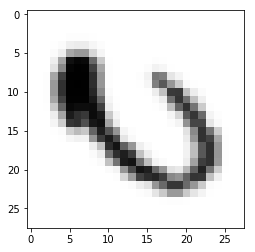

In [35]:
image_index = 7
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, img_rows, img_cols, 1))
print(pred.argmax())

# **KK Neighborhod algorithm**

In [79]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [80]:
def train_knnModel(i):  
    #Train the classifier
    print("Training KNN classifier...")
    clf = KNeighborsClassifier(n_neighbors=i)
    print("Finished trainning KNN classifier with " + str(i) + " neighbors")
    
    # Training KNN
    return clf.fit(X_train, Y_train)

knn_classificator = train_knnModel(5)

Training KNN classifier...
Finished trainning KNN classifier with 5 neighbors


The accuracy for test database is: 35.417%
Using: 1200 images


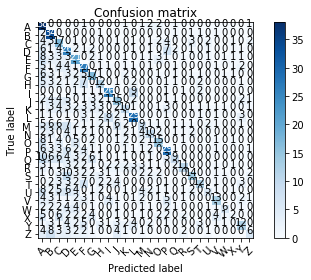

In [81]:
# Compute prediction accuracy on training set
def train_knnModel2():
    predicted = knn_classificator.predict(X_train)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_train, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_train)) + " images")
    
    plot_confusion_matrix(knn_classificator, X_train, Y_train)
    plt.show()

train_knnModel2()

The accuracy for test database is: 8.328%
Using: 1537 images


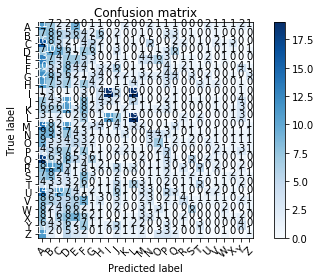

In [82]:
# Compute prediction accuracy on testing set
def test_knnModel():
    predicted = knn_classificator.predict(X_test)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_test)) + " images")
    
    plot_confusion_matrix(knn_classificator, X_test, Y_test)
    plt.show()

test_knnModel()

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [15]:
# Define the parameter values that should be searched
k_range = list(range(1, 30))

# Another parameter besides k that we might vary is the weights parameters or even the algorithm
weight_options = ['uniform', 'distance']
#algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Specify "parameter grid"
param_grid = dict(n_neighbors=k_range, weights=weight_options)

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the KNN classifier
knn = KNeighborsClassifier()

In [16]:
%%time

grid_best_scores = []
grid_best_params = []
grid_best_estimator = []

rand_best_scores = []
rand_best_params = []
rand_best_estimator = []

for _ in list(range(20)):
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid.fit(X_train, Y_train)
    grid_best_scores.append(grid.best_score_)
    grid_best_params.append(grid.best_params_)
    grid_best_estimator.append(grid.best_estimator_)

    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
    rand.fit(X_train, Y_train)
    rand_best_scores.append(rand.best_score_)
    rand_best_params.append(rand.best_params_)
    rand_best_estimator.append(rand.best_estimator_)
    
print("Finished searching the hyper parameters!")


Finished searching the hyper parameters!
CPU times: user 43.9 s, sys: 3.9 s, total: 47.9 s
Wall time: 7min 56s


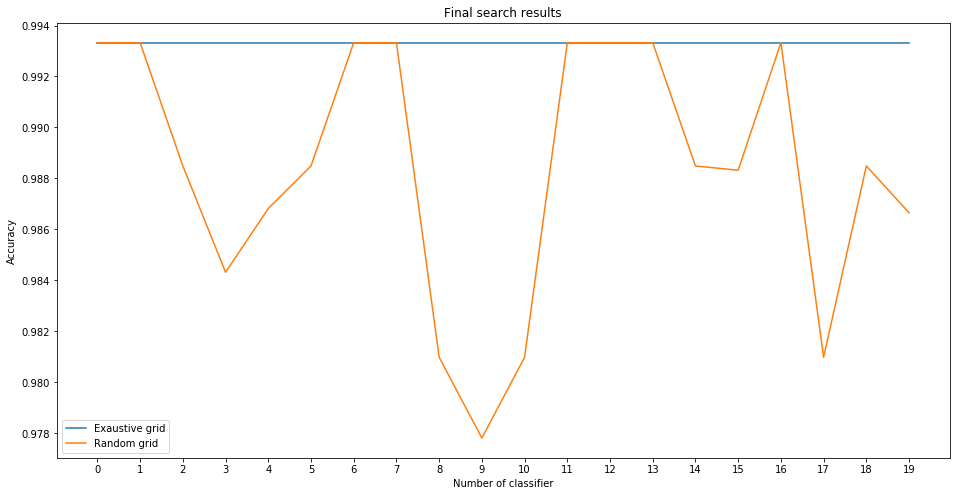

GRID SEARCH RESULTS
The best accuracy is: 99.3326659993%
The parameters is: {'n_neighbors': 1, 'weights': 'uniform'}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 99.3326659993%
The parameters is: {'n_neighbors': 1, 'weights': 'uniform'}


In [17]:
# This block draw accuracies of the differents classifiers used in the grid and random search

plt.figure(figsize=(16, 8))
plt.title("Final search results")   
plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
plt.xlabel('Number of classifier')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(grid_best_scores)))
plt.show()

print("GRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
print('\n')
print("RANDOMGRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

# Best KNN classificator

In [18]:
#Train the best classificator for a N sample of numbers
def train_best_classifier():   
    classificator = rand_best_estimator[np.argmax(rand_best_scores)]

    return classificator.fit(X_train, Y_train)

In [19]:
#Testing this new classificator accuracy with MNIST database 
def validation_database(clf):
    predicted = clf.predict(X_validation)
    
    print("The accuracy for validation database is: " + str(round((accuracy_score(Y_validation, predicted) * 100), 3)) + "%")
    print("Using: " + str(len(X_train)) + " images to train")
    print("Using: " + str(len(X_test)) + " images to test")
    print("Using: " + str(len(X_validation)) + " images to validate")

    plot_confusion_matrix(clf, X_validation, Y_validation)



In [20]:
best_knn_classificator = train_best_classifier()

The accuracy for validation database is: 56.944%
Using: 5994 images to train
Using: 4662 images to test
Using: 2664 images to validate


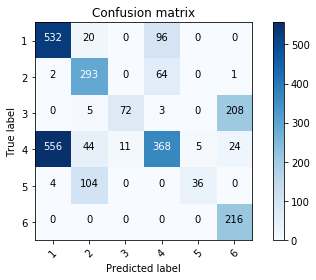

In [21]:
validation_database(best_knn_classificator)